## California Climate Risk and Adaptation Index Demo
This notebook walks through the Cal-CRAI calculation using synthetic historical data to demonstrate potential scores of resilience across California. 

**Intended Application**: I want to understand the Index results by: 
1. Calculating Cal-CRAI with equal weighted domains
2. Understanding potential weighting scenarios, where domains are weighted differently
3. Visualize the Cal-CRAI across California

#### Step 0: Set-up
First we will import several useful libraries to aid analysis. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))


from scripts.utils.file_helpers import (
    pull_csv_from_directory, upload_csv_aws
)

#### Step 1: Retrieve data
To calculate the Cal-CRAI index, we will need to read in several datasets including the  in census tract boundaries (to help with plotting). 

In [2]:
# bucket_name = 'ca-climate-index'
# aws_dir = '3_fair_data/dummy_data/'

# # Search for non-zipped files
# pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

In [3]:
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/dummy_data/'

# # Search for non-zipped files
pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'DUMMY_built_summed_indicators.csv'
Saved DataFrame as 'DUMMY_climate_indicator_product.csv'
Saved DataFrame as 'DUMMY_governance_summed_indicators.csv'
Saved DataFrame as 'DUMMY_natural_summed_indicators.csv'
Saved DataFrame as 'DUMMY_society_summed_indicators.csv'


In [4]:
# read in index data (per domain)
df = gpd.read_file('output_folder/calcrai_adjustedcols_ready.csv')
#df = df.drop(columns='field_1')
df['GEOID'] = '0' + df['GEOID']

df.head(5)

,GEOID,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry
0,06001400100,0.3729154686601496,0.1822827938671209,0.4624306606152294,0.4780778674149421,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.07746478873239446,-0.03810868031051516,-0.2120291616038881,None
1,06001400200,0.4930994824611845,0.5599091425326519,0.4165405950579929,0.4531743247983164,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.16901408450704236,-0.08821453775582216,0.041919805589307226,None
2,06001400300,0.5023001725129385,0.5252697331061897,0.2476046394351991,0.6029463346194317,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.5060362173038232,0.21312632321806618,0.0613608748481166,None
3,06001400400,0.1279470960322024,0.7234525837592277,0.5254664649520928,0.4472115047351807,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.048289738430583526,-0.10021171489061388,-0.7296476306196842,None
4,06001400500,0.3073605520414031,0.4156729131175468,0.8013111447302067,0.6453875833041038,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.5985915492957745,0.29851799576570226,-0.350546780072904,None


In [5]:
climate_domain_min_max_data = pd.read_csv('DUMMY_climate_indicator_product.csv')
df['acute_risk'] = climate_domain_min_max_data[['min_max_standardized_from_product']] # add climate col to main df

In [6]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
print("Original CRS of census tract data:")
print(ca_boundaries.crs)


Original CRS of census tract data:
EPSG:4269


#### Step 2: Calculate Cal-CRAI

Equation for weighting... need to take a nicer image/code in more visually nice
<figure>
    <img src='index_eqn.png'>
</figure>
<!-- ![equation for calculating index](calcrai_eqn.png) -->

In [7]:
def weight_domains(df, society, built, natural):
    governance_col = 'DUMMY_governance_summed_indicators_min_max_standardized'
    society_adjusted_col = 'DUMMY_society_tract_adjusted'
    built_adjusted_col = 'DUMMY_built_tract_adjusted'
    natural_adjusted_col = 'DUMMY_natural_tract_adjusted' 

    weighting = (
        df[governance_col].astype(float) + 
        (society * (df[society_adjusted_col].astype(float) * df[governance_col].astype(float))) +
        (built * (df[built_adjusted_col].astype(float) * df[governance_col].astype(float))) +
        (natural * (df[natural_adjusted_col].astype(float) * df[governance_col].astype(float)))
    )

    df['calcrai_weighted'] = weighting
    return df

In [8]:
def calculate_index(df):
    df['calcrai_score'] = df['calcrai_weighted'] / df['acute_risk'].astype(float)

    # testing for 0 values --> divide error
    df.loc[df['acute_risk'] == 0, 'calcrai_score'] = 0
    
    return df

In [9]:
df_eq = weight_domains(df, society=1, built=1, natural=1)
df_eq = calculate_index(df_eq)

Let's print some results to see the range of values

In [10]:
print('Min score / less resilience: ', df_eq['calcrai_score'].min())
print('Max score / more resilience: ', df_eq['calcrai_score'].max())
print('Mean score / average resilience: ', df_eq['calcrai_score'].mean())
print('Median score / median resilience: ', df_eq['calcrai_score'].median())

Min score / less resilience:  -4.360585964570865
Max score / more resilience:  262.77891373547675
Mean score / average resilience:  1.9152702026206374
Median score / median resilience:  1.295404950347821


In [11]:
# how many census tracts have resilience scores above 20*mean
print(len(df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())]))
df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())].head(5) # 23

# look into cause of census tracts with really large values (high governance coupled with low risk etc.)

15


,GEOID,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry,acute_risk,calcrai_weighted,calcrai_score
970,06019007202,0.0468660149511213,0.4542873367404884,0.6172465960665657,0.8674149421255699,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.2313883299798791,0.7452364149611855,-0.9009720534629405,None,0.004320,0.488655,113.106029
973,06019007300,0.5316273720529041,0.5681431005110733,0.8285426122037316,0.8011224131883551,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.6529175050301808,0.6118560338743828,0.12332928311057136,None,0.018843,1.356784,72.004362
1033,06023011200,0.4232317423806785,0.691084611016468,0.6742309631870903,0.4752718344440547,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.3450704225352113,-0.04375441072688784,-0.10571081409477531,None,0.013129,0.826264,62.934332
1274,06029005205,0.6520989074180564,0.9031800113571836,0.4094805849722642,0.5447211504735181,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.1830985915492959,0.0959774170783346,0.3778857837181046,None,0.011449,1.165793,101.826875
1756,06037143101,0.5692926969522715,0.5454287336740489,0.6177508825012606,0.5896176780077166,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.23239436619718293,0.1863091037402964,0.20291616038882146,None,0.022651,0.884478,39.048693


#### Step 3: Visualize Results

In [12]:
def to_plot(df, scenario=None, save=False):
    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry_y']
    df2 = df2.drop(columns = ['geometry_x','geometry_y'])
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4326)

    # set-up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5,6), layout='compressed')

    df2.plot(column='calcrai_score', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
            legend_kwds={'label':'Cal-CRAI scores', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        plt.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    if scenario != None:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('dummy_ca_map.png', dpi=300, bbox_inches='tight')

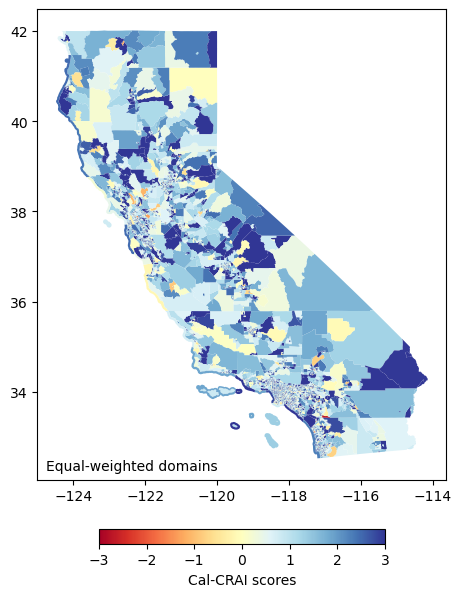

In [13]:
to_plot(df_eq)

In [14]:
# different weighting
df_fire = weight_domains(df, society=10, built=4, natural=0.5)
df_fire = calculate_index(df_fire)

In [27]:

df_fire

,GEOID,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry,acute_risk,calcrai_weighted,calcrai_score
0,06001400100,0.3729154686601496,0.1822827938671209,0.4624306606152294,0.4780778674149421,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.07746478873239446,-0.03810868031051516,-0.2120291616038881,None,0.368055,-0.004518,-0.012275
1,06001400200,0.4930994824611845,0.5599091425326519,0.4165405950579929,0.4531743247983164,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.16901408450704236,-0.08821453775582216,0.041919805589307226,None,0.283034,-0.412337,-1.456847
2,06001400300,0.5023001725129385,0.5252697331061897,0.2476046394351991,0.6029463346194317,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.5060362173038232,0.21312632321806618,0.0613608748481166,None,0.228473,-1.988606,-8.703915
3,06001400400,0.1279470960322024,0.7234525837592277,0.5254664649520928,0.4472115047351807,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.048289738430583526,-0.10021171489061388,-0.7296476306196842,None,0.145157,0.472442,3.254693
4,06001400500,0.3073605520414031,0.4156729131175468,0.8013111447302067,0.6453875833041038,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.5985915492957745,0.29851799576570226,-0.350546780072904,None,0.436470,2.882229,6.603492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.2446808510638298,0.669222032935832,0.6722138174483107,0.4398456681866012,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.341046277665996,-0.11503175723359206,-0.4829890643985419,None,0.637900,2.551370,3.999639
9125,06115041001,0.6578493387004025,0.1774559909142532,0.4543620776601109,0.7179936864258155,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,-0.09356136820925567,0.4446012702893437,0.3900364520048602,None,0.337886,0.159537,0.472163
9126,06115041002,0.4634847613571018,0.4190800681431005,0.5158850226928896,0.587513153279551,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.029175050301810928,0.1820748059280169,-0.020656136087484765,None,0.230258,0.608994,2.644837
9127,06115041101,0.4824611845888442,0.746450880181715,0.6086737266767522,0.6513504033672396,0.4732604945370903,0.4977285633162976,0.5012607160867373,0.4970185899684321,0.21428571428571394,0.3105151729004941,0.019441069258809254,None,0.212200,2.592285,12.216222


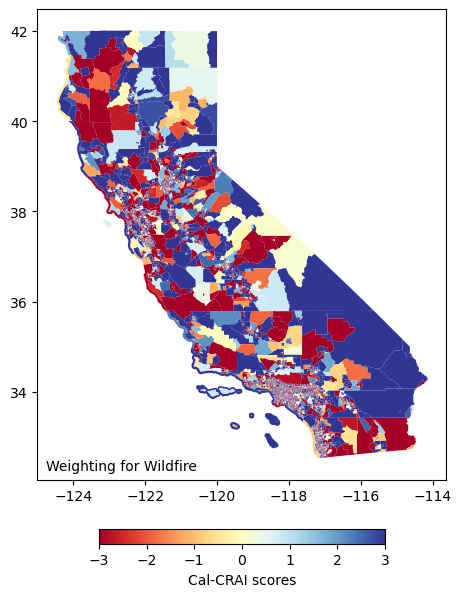

In [15]:
to_plot(df_fire, scenario='Wildfire', save=True)

Zoom in on some area of interest

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

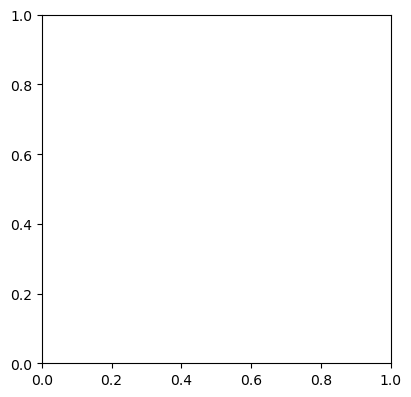

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4,6), layout='compressed')

df_fire.plot(column='crsi_results', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
        legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});
ca_boundaries.boundary.plot(ax=ax, color='black', linewidth=0.1) # only use for zoomed in plots -- otherwise it obscures the boundary
ax.set_ylim(37.5, 38.5);
ax.set_xlim(-122.7, -121.);
# fig.savefig('dummy_ca_map.png', dpi=300, bbox_inches='tight')

# Figures of each domain
* when isolating a specific domain, its value was made 10 while the rest were set to 1

In [25]:
df_eq
df_society = df_eq
df_built = df_eq
df_natural = df_eq
domain_dfs = [df_society, df_built, df_natural, df_eq]

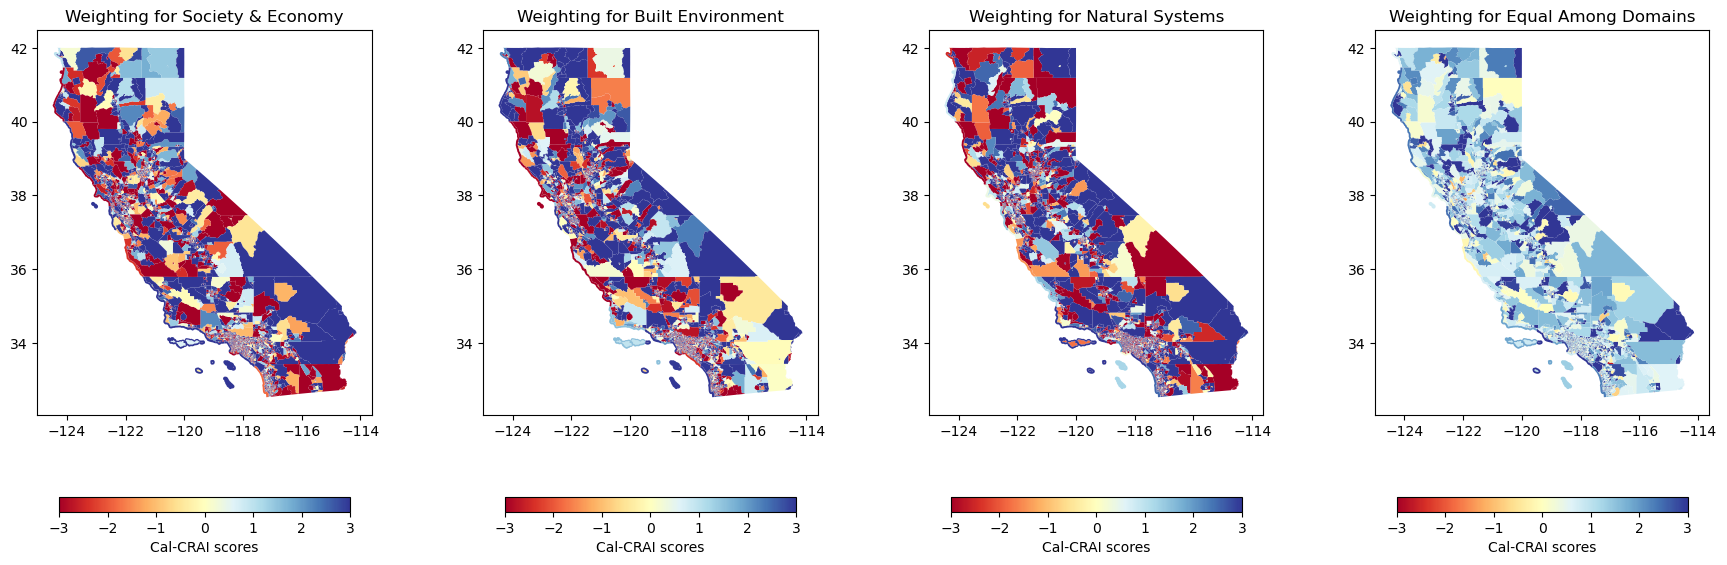

In [26]:

def to_subplot(dfs, scenarios=None, save=False):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(4.5*num_plots, 6))

    if num_plots == 1:
        axes = [axes]  # Ensure axes is always a list even if there's only one subplot

    for i, (df, scenario) in enumerate(zip(dfs, scenarios)):
        df2 = df.merge(ca_boundaries, on='GEOID')
        df2['geometry'] = df2['geometry_y']
        df2 = df2.drop(columns=['geometry_x', 'geometry_y'])
        df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4326)

        # Apply different weights to the dataframe based on the scenario
        if scenario == 'Society & Economy':
            df2 = weight_domains(df2, society=10, built=1, natural=1)
        elif scenario == 'Built Environment':
            df2 = weight_domains(df2, society=1, built=10, natural=1)
        elif scenario == 'Natural Systems':
            df2 = weight_domains(df2, society=1, built=1, natural=10)
        elif scenario == 'Equal Among Domains':
            df2 = weight_domains(df2, society=1, built=1, natural=1)
        else:
            # Handle the case if scenario is None or not recognized
            pass

        # Calculate index after applying weights
        df2 = calculate_index(df2)

        # Plot the dataframe
        df2.plot(column='calcrai_score', ax=axes[i], vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
                 legend_kwds={'label': 'Cal-CRAI scores', 'orientation': 'horizontal', 'shrink': 0.7})

        if scenario is None:
            axes[i].set_title('Equal-weighted domains')
        else:
            axes[i].set_title('Weighting for {}'.format(scenario))

        if save:
            fig.savefig(f'dummy_ca_map_{i}.png', dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

# Call the function with scenarios only# different weighting
list_scenarios = ['Society & Economy', 'Built Environment', 'Natural Systems', 'Equal Among Domains']
to_subplot(domain_dfs, list_scenarios)